# 民法問題解答

會將主問題拆分成多個子任務，子任務會個別被 Agent 執行，最後統整任務結果，自主決定繼續執行思考或回應答案。

# Config

In [1]:
from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings

import os
from dotenv import load_dotenv
load_dotenv(".env")

from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings

os.environ["LANGCHAIN_TRACING_V2"] = "true"
LANGCHAIN_API_KEY = os.environ["LANGCHAIN_API_KEY"]

Azure_OPENAI_API_KEY = os.environ["AZURE_OPENAI_API_KEY"]

gpt4o_mini = AzureChatOpenAI(
    azure_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment = "gpt-4o-mini",
    openai_api_version = os.environ["AZURE_OPENAI_API_VERSION"],
    temperature=0.5
)

gpt4o = AzureChatOpenAI(
    api_key=os.environ["AZURE_OPENAI_API_KEY"],
    azure_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment = "gpt-4o",
    openai_api_version = os.environ["AZURE_OPENAI_API_VERSION"],
    temperature=0.5
)

embeddings = AzureOpenAIEmbeddings(
    azure_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment = os.environ["AZURE_OPENAI_DEPLOYMENT_NAME_EMBEDDINGS"],
    openai_api_version = os.environ["AZURE_OPENAI_API_VERSION"],
)

from langchain_postgres import PGVector

vector_store = PGVector(
    embeddings = embeddings,
    collection_name = "civilcode",
    connection = os.environ["PGVECTOR_CONNECTION_STRING"],
)


# 民法資料存入資料庫

## RDBMS SQLite
不用額外裝套件

In [2]:
# import sqlite3
# import json

# civil_code_json_path = "../data-pre-process/民法-110-01-20.json"

# with open(file=civil_code_json_path, mode='r', encoding='utf-8') as file:
#     json_data = file.read()

# data_list = json.loads(json_data)

# conn = sqlite3.connect('civilcode.db')
# cursor = conn.cursor()

# cursor.execute('''
# CREATE TABLE IF NOT EXISTS law_articles (
#     article_number TEXT,
#     article_title TEXT,
#     article_content TEXT,
#     part_number INTEGER,
#     part_title TEXT,
#     chapter_number INTEGER,
#     chapter_title TEXT,
#     section_number INTEGER,
#     section_title TEXT,
#     subsection_number INTEGER,
#     subsection_title TEXT,
#     item_number INTEGER,
#     item_title TEXT,
#     source_url TEXT
# )
# ''')

# for data in data_list:
#     cursor.execute('''
#     INSERT INTO law_articles (
#         article_number, article_title, article_content, part_number, part_title,
#         chapter_number, chapter_title, section_number, section_title,
#         subsection_number, subsection_title, item_number, item_title, source_url
#     ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
#     ''', (
#         data['article_number'],
#         data['article_title'],
#         '\n'.join(data['artcile_content']),  # 將列表轉換為字符串
#         data['part_number'],
#         data['part_title'],
#         data['chapter_number'],
#         data['chapter_title'],
#         data['section_number'],
#         data['section_title'],
#         data['subsection_number'],
#         data['subsection_title'],
#         data['item_number'],
#         data['item_title'],
#         data['source_url']
#     ))

# conn.commit()
# conn.close()


## RDBMS PostgreSQL

In [3]:
# import psycopg2
# import json

# civil_code_json_path = "../data-pre-process/民法-110-01-20.json"

# with open(file=civil_code_json_path, mode='r', encoding='utf-8') as file:
#     json_data = file.read()

# data_list = json.loads(json_data)

# conn = psycopg2.connect(
#     dbname="civilcode",
#     user=os.environ["POSTGRES_USER"],
#     password=os.environ["POSTGRES_PASSWORD"],
#     host="localhost",
#     port="5432"
# )
# cursor = conn.cursor()

# cursor.execute('''
# CREATE TABLE IF NOT EXISTS law_articles (
#     article_number TEXT,
#     article_title TEXT,
#     article_content TEXT,
#     part_number INTEGER,
#     part_title TEXT,
#     chapter_number INTEGER,
#     chapter_title TEXT,
#     section_number INTEGER,
#     section_title TEXT,
#     subsection_number INTEGER,
#     subsection_title TEXT,
#     item_number INTEGER,
#     item_title TEXT,
#     source_url TEXT
# )
# ''')

# for data in data_list:
#     cursor.execute('''
#     INSERT INTO law_articles (
#         article_number, article_title, article_content, part_number, part_title,
#         chapter_number, chapter_title, section_number, section_title,
#         subsection_number, subsection_title, item_number, item_title, source_url
#     ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
#     ''', (
#         data['article_number'],
#         data['article_title'],
#         "".join(data['article_content']),
#         data['part_number'],
#         data['part_title'],
#         data['chapter_number'],
#         data['chapter_title'],
#         data['section_number'],
#         data['section_title'],
#         data['subsection_number'],
#         data['subsection_title'],
#         data['item_number'],
#         data['item_title'],
#         data['source_url']
#     ))

# conn.commit()
# conn.close()


## VectorDB PGvector

### 失敗：LangChain 的 .add_document() 方法

直接存會卡到API上限
S0 等級的 Azure RPM 沒辦法一次呼叫那個多次

In [4]:
# import json
# from langchain_core.documents import Document

# civil_code_json_path = "../data-pre-process/民法-110-01-20.json"

# with open(civil_code_json_path, 'r', encoding='utf-8') as file:
#     json_data = json.load(file)

# documents = []

# for entry in json_data:

#     if entry['article_content'] == ["（刪除）"]:
#         continue
    
#     article_number = entry['article_number']
#     article_title = entry['article_title']
#     article_content = "".join(entry['article_content'])
#     part_number = entry['part_number']
#     part_title = entry['part_title']
#     chapter_number = entry['chapter_number']
#     chapter_title = entry['chapter_title']
#     source_url = entry['source_url']

#     metadata = {
#         "article_number": article_number,
#         "article_title": article_title,
#         "part_number": part_number,
#         "part_title": part_title,
#         "chapter_number": chapter_number,
#         "chapter_title": chapter_title,
#         "source_url": source_url
#     }

#     document = Document(
#         page_content=article_content,
#         metadata=metadata
#     )

# import time
# for i in range(0, len(documents), 500):
#     vector_store.add_documents(documents[i:i+500])
#     time.sleep(60)

# vector_store.add_documents(documents)

#### 不清楚為啥會出錯

額度也給夠了，batch 也實施了，沒用。

```plaintext
RateLimitError: Error code: 429 - {'error': {'code': '429', 'message': 'Requests to the Embeddings_Create Operation under Azure OpenAI API version 2024-08-01-preview have exceeded call rate limit of your current OpenAI S0 pricing tier. Please retry after 86400 seconds. Please go here: https://aka.ms/oai/quotaincrease if you would like to further increase the default rate limit.'}}
```

### 成功：用外面的 Embedding 然後寫SQL存入 PGvector

用 OpenAI 的 [Batch API 處理](https://platform.openai.com/docs/api-reference/batch)，比較省錢，缺點是要手動轉換資料並寫入資料庫，很要命

需要輸入 langchain 自行建立的 `collection id`，才能符合 FK key 規則，可以去 VectorDB 的 `langchain_pg_collection`  Table 查詢。

In [5]:
# import psycopg2
# import json
# import uuid
# import os

# batchapi_embed_file_path = "../data-pre-process/batch_67679735cb7081909fb3c8a66d1336cb_output.jsonl"
# raw_json_path = "../data-pre-process/民法-110-01-20.json"

# conn = psycopg2.connect(
#     dbname="civilcode",
#     user=os.environ["POSTGRES_USER"],
#     password=os.environ["POSTGRES_PASSWORD"],
#     host="localhost",
#     port="5433" # 連線到 vectorstore
# )

# cur = conn.cursor()

# with open(batchapi_embed_file_path, 'r', encoding='utf-8') as file:
#     batchapi_embed_data_list = [json.loads(line.strip()) for line in file]

# with open(raw_json_path, 'r', encoding='utf-8') as file:
#     raw_json_data = json.load(file)

# collection_id = input("請輸入 collection_id: ")

# for i, batchapi_embed_data in enumerate(batchapi_embed_data_list):

#     if raw_json_data[i]['article_content'] == ["（刪除）"]:
#         continue

#     id = str(uuid.uuid4())
#     embedding = batchapi_embed_data['response']['body']['data'][0]['embedding']
#     document = raw_json_data[i]['article_content']
#     cmetadata = json.dumps(raw_json_data[i])

#     cur.execute("""
#     INSERT INTO langchain_pg_embedding (id, collection_id, embedding, document, cmetadata) 
#     VALUES (%s, %s, %s, %s, %s);
#     """, (
#         id, 
#         collection_id, 
#         embedding, 
#         document, 
#         cmetadata
#     ))

# conn.commit()

# cur.close()
# conn.close()


# LangGraph

[plan and excute](https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/plan-and-execute)

### Define tools

In [6]:
from langchain_core.tools import tool
from pydantic import BaseModel
import json
import psycopg2
import os

@tool(response_format="content_and_artifact")
def search_civilcode_by_embedding(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=5)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

class SearchCivilcodeByArtcileForm(BaseModel):
    """
        index for civilcode:
        1. 編(Part)
        2. 章(Chapter)
        3. 節(Section)
        4. 款(Subsection)
        5. 目(Item)
        6. 條(Article)
    """
    article_number: str

@tool(response_format="content_and_artifact")
def search_civilcode_by_articleNumber(civilcode_search_form: SearchCivilcodeByArtcileForm):
    """Retrieve information related to a query."""
    article_number = civilcode_search_form.article_number
    
    if not article_number:
        return {"error": "article_number is required"}, None
    
    conn = psycopg2.connect(
        dbname="civilcode",
        user=os.environ["POSTGRES_USER"],
        password=os.environ["POSTGRES_PASSWORD"],
        host="localhost",
        port="5432"
    )
    cursor = conn.cursor()
    
    query = "SELECT * FROM law_articles WHERE article_number = %s"
    cursor.execute(query, (article_number,))
    result = cursor.fetchone()
    
    conn.close()
    
    if result:
        columns = [
            "article_number", "article_title", "article_content", "part_number", "part_title",
            "chapter_number", "chapter_title", "section_number", "section_title",
            "subsection_number", "subsection_title", "item_number", "item_title", "source_url"
        ]
        result_dict = dict(zip(columns, result))
        return result_dict["article_content"], result_dict.get("article_number")
    else:
        return {"error": "Article not found"}, None
    
@tool(response_format="content")
def show_all_civilcode_index():
    """你還可以根據領域來查詢相關法條，這是第一步：先使用show_all_civilcode_index工具，此工具將會給你所有可用查詢的篇章節。"""
    with open("../data-pre-process/civilcode-index-110-01-20.json", "r", encoding="utf-8") as file:
        index_data = json.load(file)
    titles = [item["title"] for item in index_data]
    result = "\n".join(titles)
    return result
    
@tool(response_format="content")
def search_civilcode_by_index(index_title: str):
    """你還可以根據領域來查詢相關法條，這是第二步：對其輸入你想查詢的篇章節，例如：總則編 - 人章 - 法人節，就會回傳整個指定篇章節的法條。"""
    with open("../data-pre-process/civilcode-index-110-01-20.json", "r", encoding="utf-8") as file:
        index_data = json.load(file)

        part_number, chapter_number, section_number = None, None, None
        
        for item in index_data:
            if item["title"] == index_title:
                part_number = item["part_number"]
                chapter_number = item["chapter_number"]
                section_number = item["section_number"]
                break

        if part_number is None:
            return {"error": "Index not found"}

    conn = psycopg2.connect(
        dbname="civilcode",
        user=os.environ["POSTGRES_USER"],
        password=os.environ["POSTGRES_PASSWORD"],
        host="localhost",
        port="5432"
    )
    cursor = conn.cursor()

    # Construct SQL query based on the available part_number, chapter_number, section_number
    if part_number is not None and chapter_number is not None and section_number is not None:
        query = """
            SELECT * FROM law_articles
            WHERE part_number = %s AND chapter_number = %s AND section_number = %s
        """
        cursor.execute(query, (part_number, chapter_number, section_number))
    elif part_number is not None and chapter_number is not None:
        query = """
            SELECT * FROM law_articles
            WHERE part_number = %s AND chapter_number = %s
        """
        cursor.execute(query, (part_number, chapter_number))
    elif part_number is not None:
        query = """
            SELECT * FROM law_articles
            WHERE part_number = %s
        """
        cursor.execute(query, (part_number,))

    results = cursor.fetchall()

    cursor.close()
    conn.close()

    return results

    
    
tools = [search_civilcode_by_embedding, search_civilcode_by_articleNumber, show_all_civilcode_index, search_civilcode_by_index]

### define the State

In [7]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


# class PlanExecute(TypedDict):
#     input: str
#     plan: List[str]
#     past_steps: Annotated[List[Tuple], operator.add]
#     response: str
#     current_step_index: int

class ParallelPlanExecute(TypedDict):
    input: str
    plan: List[str]
    # past_steps 將一次性收集所有並行任務的結果
    past_steps: Annotated[List[Tuple[str, str]], operator.add]
    response: str


### define a excuter

In [8]:
from langgraph.prebuilt import create_react_agent

prompt = "你是一位有邏輯的專業法律問題解答者，你僅會仔細思考後回答你被指派的子任務，你不會做出多餘的動作去回答主要問題。"\
    "請注意：法律內容是會更動的，請不要使用不確定是否正確的知識回答問題，務必使用工具來查詢正確知識，確保回答所用的資料是最新的。"\
    "此外，若使用工具搜尋出的法條仍包含其他條例，例如：{此情況不適用於第五十一條情況。}，你可以繼續使用search_civilcode_by_articleNumber工具搜尋該法條具體內容，確保資訊完整詳細。"\
    # "你還可以根據領域來查詢相關法條，順序是：先使用show_all_civilcode_index工具，此工具將會給你所有可用查詢的篇章節。"\
    # "接下來，search_civilcode_by_index 工具對其輸入你想查詢的篇章節，例如：總則編 - 人章 - 法人節，就會回傳整個指定篇章節的法條。"

llm = gpt4o
agent_executor = create_react_agent(llm, tools, state_modifier=prompt)

### planning step

In [9]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="這些是該執行的計劃任務，理應桉順序被執行"
    )
    

In [10]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            你是問題拆解專家。你的核心職責是將接收到的複雜問題，拆解成一系列完全獨立、可並行執行的子任務。
            核心要求：
            - 深度分析與拆解： 深入理解問題的各個面向，將其分解為多個邏輯上獨立的分析單元或資訊收集任務。
            - 絕對獨立性： 每個子任務必須是自包含 (Self-contained) 的。執行者在執行單一子任務時，無需，也不能參考或依賴任何其他子任務的輸入或輸出。想像每個子任務都被發送到一個獨立的房間，執行者只看得到自己那份任務描述。
            - 可並行執行： 設計的子任務必須能夠同時分派給不同的執行者，並行處理，彼此之間沒有執行順序的依賴。
            - 清晰明確的描述： 為每個子任務提供完整、無歧義的指示和所需背景信息（如果有的話，應直接包含在任務描述中，而非暗示執行者去查找其他地方）。確保執行者僅憑任務描述就能準確理解並完成工作。
            - 嚴禁整合與決策： 絕對禁止建立任何需要整合其他子任務結果、進行比較分析、或推導最終結論/答案的子任務。你的工作在拆解完成後即結束。
            - 專注於資訊生成： 子任務的目標應該是生成特定的資訊片段、分析特定觀點、或評估特定選項的某個方面，而不是得出整體的解決方案。
            最終流程說明（供你理解，非你的任務）：
            1. 你拆解出的所有子任務將被分發給不同的執行者。
            2. 所有執行者完成各自獨立的任務後，會將結果提交給一位最終決策者。
            3. 最終決策者將負責審閱所有子任務的成果，並進行必要的整合、比較與最終決策。
            4. 你無需規劃或考慮任何關於整合結果的步驟。
            """
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | gpt4o.with_structured_output(Plan)

### re-plan step

In [11]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="如果你想要回應使用者，請使用「Response」。如果你需要進一步使用工具來獲得答案，請使用「Plan」。"
    )


replanner_prompt = ChatPromptTemplate.from_template(
"""
你的目標、要解決的問題是：
{input}

你原本的計劃是：
{plan}

目前為止已完成的所有任務內容：
{past_steps}

請根據上文仔細想想是否需要更新你的計劃。如果不再需要其他步驟並且答案能回應問題，請回應該答案給使用者。如果還需要進一步的步驟，請給予新的計劃，你僅能在原先的任務後接續規劃新任務，做要新增請直接給予欲新增的任務。\
請注意：你僅能新增你認為需要的新任務，或做總結回應使用者答案。"""
)


replanner = replanner_prompt | gpt4o.with_structured_output(Act)

### create the Graph

In [12]:
from typing import Literal
from langgraph.graph import END
from concurrent.futures import ThreadPoolExecutor, as_completed

# def execute_step(state: PlanExecute):
#     """
#     執行當前步驟，並更新執行狀態。
#     """
#     plan = state["plan"]
#     plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
#     current_step_index = state.get("current_step_index", 0)  # 獲取當前步驟索引

#     if current_step_index >= len(plan):
#         raise IndexError(f'"Current step index is out of range for the plan. Current step index: {current_step_index}, Plan length: {len(plan)}"')

#     task = plan[current_step_index]
#     task_formatted = f"這是被已拆分的主要問題：{state["input"]}，在拆分的任務中，你被分配到了第 {current_step_index + 1} 個任務，內容為： {task}."

#     agent_response = agent_executor.invoke(
#         {"messages": [("user", task_formatted)]}
#     )

#     # 更新 past_steps 和 current_step_index
#     past_steps = state.get("past_steps", [])
#     past_steps.append((task, agent_response["messages"][-1].content))
#     state["past_steps"] = past_steps
#     state["current_step_index"] = current_step_index + 1  # 增加索引

#     if current_step_index + 1 == len(plan):
#         pass
#     else:
#         return execute_step(state)

def execute_parallel(state: ParallelPlanExecute):
    """
    並行執行計劃中的所有任務。
    """
    plan = state.get("plan", [])
    original_input = state.get("input", "")
    past_steps_results = [] # 用於收集 (任務, 結果)

    if not plan:
        print("計劃為空，無需執行。")
        state["past_steps"] = []
        return state

    # --- 併發執行 ---
    # 創建一個字典來儲存 future 到 任務/索引 的映射，以便稍後匹配結果
    future_to_task_info = {}
    # 使用 ThreadPoolExecutor 處理 I/O 密集型任務 (如 LLM API 調用)
    # 如果 agent_executor 非常 CPU 密集且受 GIL 限制，可考慮 ProcessPoolExecutor
    with ThreadPoolExecutor(max_workers=4) as executor:
        print(f"提交 {len(plan)} 個任務進行並行執行...")
        # 提交所有任務
        for i, task in enumerate(plan):
            task_formatted = f"這是被已拆分的主要問題：{original_input}，在拆分的任務中，你被分配到了第 {i + 1} 個任務，內容為： {task}."
            # 提交任務給執行器，並保存 future
            # 我們傳遞原始任務字符串 'task' 以便稍後在結果中包含它
            future = executor.submit(
                agent_executor.invoke, {"messages": [("user", task_formatted)]}
            )
            future_to_task_info[future] = {"index": i, "task": task}

        # 使用 as_completed 按完成順序獲取結果
        results_dict = {} # 用字典暫存結果，鍵為索引，以便排序
        for future in as_completed(future_to_task_info):
            task_info = future_to_task_info[future]
            task_index = task_info["index"]
            original_task = task_info["task"]
            try:
                # 從 future 獲取結果
                agent_response = future.result()
                # 提取需要的內容
                response_content = agent_response["messages"][-1].content
                results_dict[task_index] = (original_task, response_content)
                print(f"任務 {task_index + 1} ('{original_task[:30]}...') 已完成。")
            except Exception as e:
                print(f"任務 {task_index + 1} ('{original_task[:30]}...') 執行出錯: {e}")
                # 記錄錯誤信息
                results_dict[task_index] = (original_task, f"ERROR: {e}")

    # --- 整理結果 ---
    # 按原始任務順序排序結果
    ordered_results = [results_dict[i] for i in range(len(plan))]

    # --- 更新狀態 ---
    # 將所有結果一次性更新到 past_steps
    # 注意：如果 past_steps 使用 operator.add，它會附加。
    # 在這種並行模式下，我們通常希望覆蓋或設置初始結果。
    # 這裡直接賦值，假設這是第一輪或需要覆蓋。
    state["past_steps"] = ordered_results
    # print(f"所有 {len(plan)} 個並行任務已完成。")

    # 返回更新後的狀態
    # 在 LangGraph 中，節點函數通常返回狀態字典或其修改
    return state # 或者 return {"past_steps": ordered_results} 如果只想更新特定鍵


def plan_step(state: ParallelPlanExecute):
    """
    根據初始輸入生成計畫。
    """
    plan = planner.invoke({"messages": [("user", state["input"])]})
    return {
        "plan": plan.steps,
        "current_step_index": 0  # 初始化 current_step_index
    }


def replan_step(state: ParallelPlanExecute):
    """
    更新計畫邏輯，實現增量更新。
    """
    output = replanner.invoke(state)

    if isinstance(output.action, Response):
        return {"response": output.action.response}

    elif isinstance(output.action, Plan):
        # 現有的未執行步驟
        current_index = state.get("current_step_index", 0)
        existing_steps = state["plan"][current_index:]

        # 新生成的步驟
        new_steps = output.action.steps

        # 合併步驟：保留未完成的步驟，並附加新的步驟
        combined_steps = existing_steps + new_steps

        print(f"Replanning executed. Previous plan length: {len(state['plan'])}, "
              f"Remaining steps: {len(existing_steps)}, New steps: {len(new_steps)}, "
              f"Combined plan length: {len(combined_steps)}")

        return {"plan": combined_steps}

    else:
        raise ValueError("Unexpected output type from replanner.")

def should_end(state: ParallelPlanExecute):
    """
    判斷任務是否應該結束。
    """
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"


In [13]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(ParallelPlanExecute)

workflow.add_node("planner", plan_step)

workflow.add_node("agent", execute_parallel)

workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

workflow.add_edge("planner", "agent")

workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    should_end,
    ["agent", END],
)

app = workflow.compile()

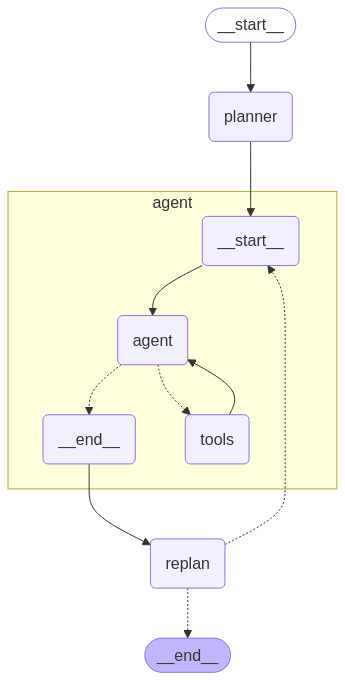

In [14]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [15]:
config = {"recursion_limit": 50}
# inputs = {"input": "第8題：甲向乙承租其所有之 A 屋。依民法規定，下列敘述，何者錯誤？A. 若乙不同意，甲不得將 A 屋全部轉租第三人丙。B. 若甲乙雙方無反對之約定，甲得將 A 屋一部分轉租第三人丙。C. 若甲將 A 屋違法轉租第三人丙，甲丙間之租賃契約仍為有效。D.若甲將 A 屋合法轉租第三人丙，則因丙應負責任之事由所生之損害，甲不負賠償責任"}
# inputs = {"input": "第10題：關於旅遊營業人變更旅遊內容，下列敘述，何者正確？A. 旅遊營業人僅得於因不可抗力或不可歸責之事由時，始得變更旅遊內容。B. 旅遊營業人任意變更旅遊行程內容項目，旅客僅得終止契約，不得解除契約。C. 旅遊營業人在銷售行程資料載明「航班及飯店僅供參考」，即得因目的地當地情形隨時變更航班與飯店。D. 旅遊營業人任意變更旅遊行程內容項目，旅客僅得減少價金。"}
# inputs = {"input": "民法繼承篇裡面說了什麼？"}
inputs = {"input": "第14題：甲將收藏多年價值新臺幣（下同）60 萬元之古董花瓶委託乙清潔上釉，未料乙竟將此花瓶整理後用自己名義以 80 萬元出售給收藏家丙後，將價金拿去酒店花光。下列敘述，何者正確？A.甲得向乙主張不法管理，請其返還 80 萬元。B.甲得向乙主張成立侵權行為，請求乙賠償 80 萬元，並得請求精神慰撫金。C.甲得向乙主張不當得利，請乙返還 80 萬元。但因利益已花完，故已無須返還。D.甲得主張乙無權代理，請求乙返還 80 萬元。"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['分析選項A中對於甲是否可向乙主張不法管理並請求返還80萬元的法律依據。', '分析選項B中甲是否可向乙主張侵權行為並請求賠償80萬元及精神慰撫金的法律基礎。', '分析選項C中甲是否可向乙主張不當得利並請求返還80萬元，以及利益已花完的法律影響。', '分析選項D中甲是否可主張乙無權代理並請求返還80萬元的法律依據。']}
提交 4 個任務進行並行執行...
任務 4 ('分析選項D中甲是否可主張乙無權代理並請求返還80萬元的法律依...') 已完成。
任務 3 ('分析選項C中甲是否可向乙主張不當得利並請求返還80萬元，以及...') 已完成。
任務 2 ('分析選項B中甲是否可向乙主張侵權行為並請求賠償80萬元及精神...') 已完成。
任務 1 ('分析選項A中對於甲是否可向乙主張不法管理並請求返還80萬元的...') 已完成。
{'input': '第14題：甲將收藏多年價值新臺幣（下同）60 萬元之古董花瓶委託乙清潔上釉，未料乙竟將此花瓶整理後用自己名義以 80 萬元出售給收藏家丙後，將價金拿去酒店花光。下列敘述，何者正確？A.甲得向乙主張不法管理，請其返還 80 萬元。B.甲得向乙主張成立侵權行為，請求乙賠償 80 萬元，並得請求精神慰撫金。C.甲得向乙主張不當得利，請乙返還 80 萬元。但因利益已花完，故已無須返還。D.甲得主張乙無權代理，請求乙返還 80 萬元。', 'plan': ['分析選項A中對於甲是否可向乙主張不法管理並請求返還80萬元的法律依據。', '分析選項B中甲是否可向乙主張侵權行為並請求賠償80萬元及精神慰撫金的法律基礎。', '分析選項C中甲是否可向乙主張不當得利並請求返還80萬元，以及利益已花完的法律影響。', '分析選項D中甲是否可主張乙無權代理並請求返還80萬元的法律依據。'], 'past_steps': [('分析選項A中對於甲是否可向乙主張不法管理並請求返還80萬元的法律依據。', '根據《民法》第174條與第175條的規定：\n\n1. **第174條**規定：\n   - 管理人若違反本人明示或可得推知之意思，進行事務的管理，對於因此管理所造成的損害，雖無過失，亦應負賠償責任。\n   - 但若管理是為了盡公益義務、履行法定扶養義務，或本人的意思違反公共秩序與善良風俗，則不適用此條。\n\n2